# Overview

In this project, I will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the animes in [AnimeLens Datasets](https://grouplens.org/datasets/animelens/latest/)

## [Recommender system](https://en.wikipedia.org/wiki/Recommender_system)
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors

Recommender systems typically produce a list of recommendations through collaborative filtering or through content-based filtering

This project will focus on collaborative filtering and use Alternating Least Squares (ALS) algorithm to make anime predictions


## [Alternating Least Squares](https://endymecy.gitbooks.io/spark-ml-source-analysis/content/%E6%8E%A8%E8%8D%90/papers/Large-scale%20Parallel%20Collaborative%20Filtering%20the%20Netflix%20Prize.pdf)
ALS is one of the low rank matrix approximation algorithms for collaborative filtering. ALS decomposes user-item matrix into two low rank matrixes: user matrix and item matrix. In collaborative filtering, users and products are described by a small set of latent factors that can be used to predict missing entries. And ALS algorithm learns these latent factors by matrix factorization


## Data Sets
I use [AnimeLens Datasets](https://grouplens.org/datasets/animelens/latest/).
This dataset (ml-latest.zip) describes 5-star rating and free-text tagging activity from [AnimeLens](http://animelens.org), a anime recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 animes. These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 animes. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `animes.csv`, `ratings.csv` and `tags.csv`.

## Project Content
1. Load Data
2. Spark SQL and OLAP
3. Spark ALS based approach for training model
4. ALS Model Selection and Evaluation
5. Model testing
6. Make anime recommendation to myself

In [35]:
import os
import time
import load_recommender_data

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
path_in_str = 'user_data1.0.json'
df_merge, anime_df, user_df = load_recommender_data.load_recommender_data(path_in_str)

/home/lucifer/Documents/sem7/CS685/repo/Codagami_Anime_Recommender/load_recommender_data.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  user_df = melt_series(df.data).to_frame().join(df.drop('data', 1))
/home/lucifer/Documents/sem7/CS685/repo/Codagami_Anime_Recommender/env/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/lucifer/Documents/sem7/CS685/repo/Codagami_Anime_Recommender/load_recommender_data.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [37]:
anime_df = anime_df[['anime_id', 'title', 'genres_name']]
anime_df = anime_df.rename({'genres_name': 'genres'}, axis=1)

In [38]:
anime_df = anime_df.astype({'anime_id': int, 'title': str, 'genres': str})

In [39]:
df_ratings = df_merge[['user_id', 'anime_id', 'rating_y']].copy()
df_ratings = df_ratings.rename({'rating_y': 'rating'}, axis=1)
df_ratings = df_ratings.astype({'anime_id': int, 'user_id': int, 'rating': float})
df_ratings.reset_index(inplace=True)
df_ratings['rating'] = ((df_ratings['rating'] / 10.0)*4.0) + 1
df_ratings = df_ratings[['user_id', 'anime_id', 'rating']]

In [40]:
df_ratings

,user_id,anime_id,rating
0,1,1,1.0
1,2,1,3.8
2,3,1,5.0
3,5,1,4.2
4,6,1,5.0
...,...,...,...
49725,76,49738,1.0
49726,77,49738,1.0
49727,82,49738,1.0
49728,86,49738,1.0


In [41]:
df_ratings.to_csv('ratings.csv', index=False)
anime_df.to_csv('animes.csv', index=False)

In [42]:
# spark config
spark = SparkSession \
    .builder \
    .appName("anime recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [43]:
animes = spark.read.load('animes.csv', format='csv', header=True, inferSchema=True)

## Spark ALS based approach for training model
1. Reload data
2. Split data into train, validation, test
3. ALS model selection and evaluation
4. Model testing

### Reload data
We will use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [44]:
# load data
anime_rating = sc.textFile('ratings.csv')
# preprocess data -- only need ["userId", "animeId", "rating"]
header = anime_rating.take(1)[0]
rating_data = anime_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(1, 1, 1.0), (2, 1, 3.8), (3, 1, 5.0)]

### Split data
Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [45]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[27] at RDD at PythonRDD.scala:53

### ALS model selection and evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [46]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [47]:
# hyper-param config
num_iterations = 10
# ranks = [8, 10, 12, 14, 16, 18, 20]
ranks = [8]
# reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]
reg_params = [0.05]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.05: validation RMSE is 1.583840405551869

The best model has 8 latent factors and regularization = 0.05
Total Runtime: 14.34 seconds


### ALS model learning curve
As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [48]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

21/11/19 17:08:51 WARN BlockManager: Task 1492 already completed, not releasing lock for rdd_25_0
21/11/19 17:10:39 WARN BlockManager: Task 1766 already completed, not releasing lock for rdd_25_0
21/11/19 17:12:54 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 134521 ms exceeds timeout 120000 ms
21/11/19 17:12:54 WARN SparkContext: Killing executors is not supported by current scheduler.


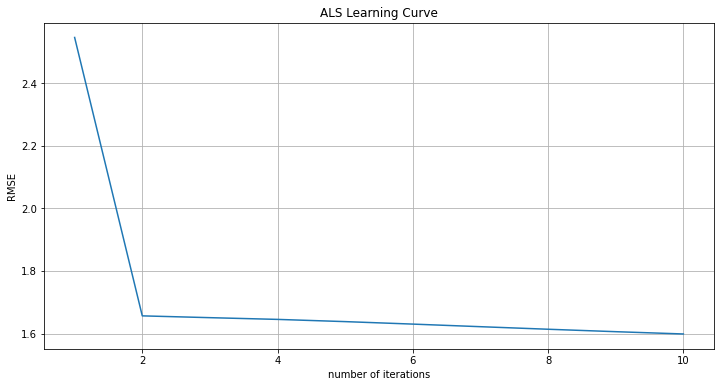

In [49]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 20)

After 3 iterations, alternating gradient descend starts to converge at an error around 0.8

### Model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [ ]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8156


### Make anime recommendation to myself
We need to define a function that takes new user's anime rating and output top 10 recommendations

In [ ]:
def get_animeId(df_animes, fav_anime_list):
    """
    return all animeId(s) of user's favorite animes
    
    Parameters
    ----------
    df_animes: spark Dataframe, animes data
    
    fav_anime_list: list, user's list of favorite animes
    
    Return
    ------
    animeId_list: list of animeId(s)
    """
    animeId_list = []
    for anime in fav_anime_list:
        animeIds = df_animes \
            .filter(animes.title.like('%{}%'.format(anime))) \
            .select('animeId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        animeId_list.extend(animeIds)
    return list(set(animeId_list))


def add_new_user_to_data(train_data, animeId_list, spark_context):
    """
    add new rows with new user, user's anime and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    animeId_list: list, list of animeId(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, animeId, max_rating) for animeId in animeId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_animes, animeId_list):
    """
    return a rdd with the userid and all animes (except ones in animeId_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_animes: spark Dataframe, animes data
    
    animeId_list: list, list of animeId(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_animes.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in animeId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_animes, 
                        fav_anime_list, n_recommendations, spark_context):
    """
    return top n anime recommendation based on user's input list of favorite animes


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_animes: spark Dataframe, animes data

    fav_anime_list: list, user's list of favorite animes

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n anime recommendations
    """
    # modify train data by adding new user's rows
    animeId_list = get_animeId(df_animes, fav_anime_list)
    train_data = add_new_user_to_data(ratings_data, animeId_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_animes, animeId_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n animeId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return anime titles
    return df_animes.filter(animes.animeId.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

Let's pretend I am a new user in this recommender system. I will input a handful of my all-time favorite animes into the system. And then the system should output top N anime recommendations for me to watch

In [ ]:
# my favorite animes
my_favorite_animes = ['Cowboy Bebop']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.05}, 
    ratings_data=rating_data, 
    df_animes=animes, 
    fav_anime_list=my_favorite_animes, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_animes[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for Iron Man:
1: Pearl Jam: Immagine in Cornice - Live in Italy 2006 (2007)
2: "Diebuster ""Top wo Narae 2"" (2004)"
3: Dinosaur Island (1994)
4: Melhores do Mundo - Hermanoteu na Terra de Godah (2009)
5: Into Pitch Black (2000)
6: Kizumonogatari II: Passionate Blood (2016)
7: Countdown (2004)
8: Heroes Above All (2017)
9: Stone Cold Steve Austin: The Bottom Line on the Most Popular Superstar of All Time (2011)
10: WWE: Ladies and Gentlemen, My Name Is Paul Heyman (2014)


This list of anime recommendations look completely different than the list from my previous **KNN** model recommender. Not only it recommends animes outside of years between 2007 and 2009 periods, but also recommends animes that were less known. So this can offer users some elements of suprise so that users won't get bored by getting the same popular animes all the time.

So this list of recommendations can be blended into the previous list of recommendations from **KNN** model recommender